In [1]:
import pandas as pd
from IPython.display import display
import re
import numpy as np
from IPython.display import Image
import folium
from folium import plugins
from collections import Counter
import requests
import json
from config import gkey
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results_df = pd.read_csv("Resources/Accidental_Drug_Related_Deaths_2012-2017_cleaned.csv")
Counter(results_df["Race"])

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Unknown': 16,
         'Asian, Other': 14,
         nan: 9,
         'Hispanic, Black': 17,
         'Other': 7,
         'Asian Indian': 9,
         'Chinese': 2,
         'Native American, Other': 1,
         'Hawaiian': 1})

In [3]:
results_df["Race"] = results_df["Race"].replace(['Unknown','Asian Indian','Chinese','Native American, Other', 'Hawaiian'],'Other')
results_df['Race'] = results_df['Race'].fillna('Other')

In [4]:
race_counts = Counter(results_df["Race"])
race_counts

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Other': 45,
         'Asian, Other': 14,
         'Hispanic, Black': 17})

In [5]:
sex_counts = Counter(results_df["Sex"])
sex_counts

Counter({'Male': 2992, 'Female': 1085, nan: 2})

In [6]:
results_df["Age"].describe()

count    4078.000000
mean       41.755763
std        12.318326
min        14.000000
25%        31.000000
50%        42.000000
75%        52.000000
max        87.000000
Name: Age, dtype: float64

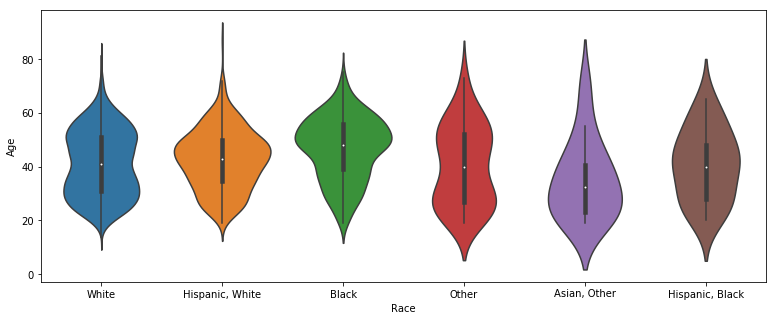

In [7]:
plt.figure(figsize=(13,5))
sns.violinplot(x="Race",y="Age",data=results_df)

plt.show()

In [8]:
age_groups = [0,17, 24,34,44,54,64,120]
age_grp_names = ["<18years","18-24 years","25 to 34 years","35 to 44 years","45 to 54 years","55 to 65 years","65 years and older"]
results_df["Age Group"] = pd.cut(results_df["Age"],age_groups,labels=age_grp_names)

In [9]:
race_age_df = results_df.groupby(["Race","Age Group","Sex"])["CaseNumber"].count()
race_age_df

Race             Age Group           Sex   
Asian, Other     18-24 years         Male        4
                 25 to 34 years      Male        3
                 35 to 44 years      Female      4
                 45 to 54 years      Female      1
                 55 to 65 years      Female      1
                 65 years and older  Male        1
Black            18-24 years         Female      4
                                     Male        7
                 25 to 34 years      Female      8
                                     Male       37
                 35 to 44 years      Female     18
                                     Male       49
                 45 to 54 years      Female     37
                                     Male       76
                 55 to 65 years      Female     17
                                     Male       63
                 65 years and older  Female      2
                                     Male       11
Hispanic, Black  18-24 years         F

In [10]:
race_df = results_df.groupby("Race")["CaseNumber"].count()
race_order = race_df.sort_values(ascending=False).index

In [11]:
bars_male=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Male")])
        except:
            age_bins.append(0)
    bars_male.append(age_bins)
bars_male

[[4, 208, 652, 541, 567, 331, 38],
 [0, 17, 64, 119, 102, 42, 8],
 [0, 7, 37, 49, 76, 63, 11],
 [0, 6, 8, 6, 6, 6, 2],
 [0, 0, 4, 3, 3, 2, 1],
 [0, 4, 3, 0, 0, 0, 1]]

In [12]:
bars_female=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Female")])
        except:
            age_bins.append(0)
    bars_female.append(age_bins)
bars_female

[[5, 73, 207, 192, 249, 149, 25],
 [0, 4, 23, 14, 25, 11, 1],
 [0, 4, 8, 18, 37, 17, 2],
 [0, 2, 3, 1, 4, 1, 0],
 [0, 2, 0, 2, 0, 0, 0],
 [0, 0, 0, 4, 1, 1, 0]]

In [13]:
stacking_bars_male = []
stacking_bars_male.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_male)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_male[j])
    stacking_bars_male.append(list(age_bar))
stacking_bars_male

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [4.0, 208.0, 652.0, 541.0, 567.0, 331.0, 38.0],
 [4.0, 225.0, 716.0, 660.0, 669.0, 373.0, 46.0],
 [4.0, 232.0, 753.0, 709.0, 745.0, 436.0, 57.0],
 [4.0, 238.0, 761.0, 715.0, 751.0, 442.0, 59.0],
 [4.0, 238.0, 765.0, 718.0, 754.0, 444.0, 60.0]]

In [14]:
stacking_bars_female = []
stacking_bars_female.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_female)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_female[j])
    stacking_bars_female.append(list(age_bar))
stacking_bars_female

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [5.0, 73.0, 207.0, 192.0, 249.0, 149.0, 25.0],
 [5.0, 77.0, 230.0, 206.0, 274.0, 160.0, 26.0],
 [5.0, 81.0, 238.0, 224.0, 311.0, 177.0, 28.0],
 [5.0, 83.0, 241.0, 225.0, 315.0, 178.0, 28.0],
 [5.0, 85.0, 241.0, 227.0, 315.0, 178.0, 28.0]]

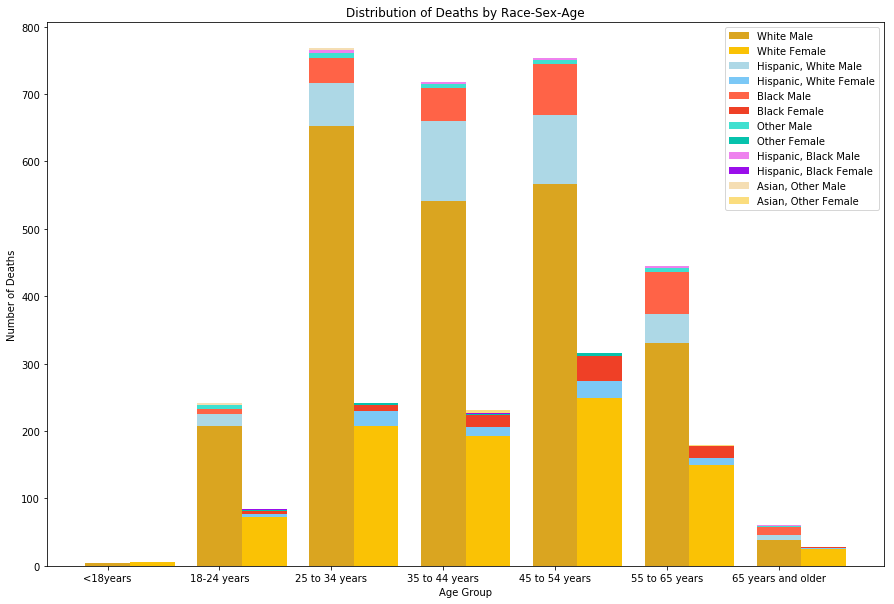

In [15]:
colors_list = ["goldenrod","lightblue","tomato","turquoise","violet","wheat", "sienna","plum","orchid"]

xticks = np.arange(1,len(age_groups))
plt.figure(figsize=(15,10))
w = 0.4
for i, race in enumerate(race_order):

    plt.bar(xticks,bars_male[i],bottom = stacking_bars_male[i],color=colors_list[i], label=race+" Male", width=w)
    plt.bar(xticks+w,bars_female[i],bottom = stacking_bars_female[i], color="xkcd:"+colors_list[i],\
            label=race+" Female", width=w)

plt.xticks(xticks, age_grp_names)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Distribution of Deaths by Race-Sex-Age")
plt.legend()
plt.show()